In [2]:
!pip install yfinance tensorflow scikit-learn matplotlib

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [20]:
# Download Stock Data (Apple as example)
data = yf.download("AAPL", start="2018-01-01", end="2023-12-31")
print(data.head())

/tmp/ipython-input-3899989183.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2018-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.380993  40.390372  39.677736  39.888715  102223600
2018-01-03  40.373959  40.917812  40.310668  40.444285  118071600
2018-01-04  40.561493  40.664638  40.338796  40.446626   89738400
2018-01-05  41.023300  41.110034  40.566184  40.657607   94640000
2018-01-08  40.870930  41.166296  40.772471  40.870930   82271200


In [21]:
# Preprocess Data (Close prices only)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

X_train, y_train = [], []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
# Build RNN Model (LSTM)
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# Train Model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0694
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0050
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0041
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0043
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0044
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0035
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0037
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0032
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0034
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0030
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0029
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0031
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0028
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0026
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0027
Epoc

In [24]:
# Prepare Test Data (last 80 days)
test_data = scaled_data[-80:]
X_test, y_test = [], []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


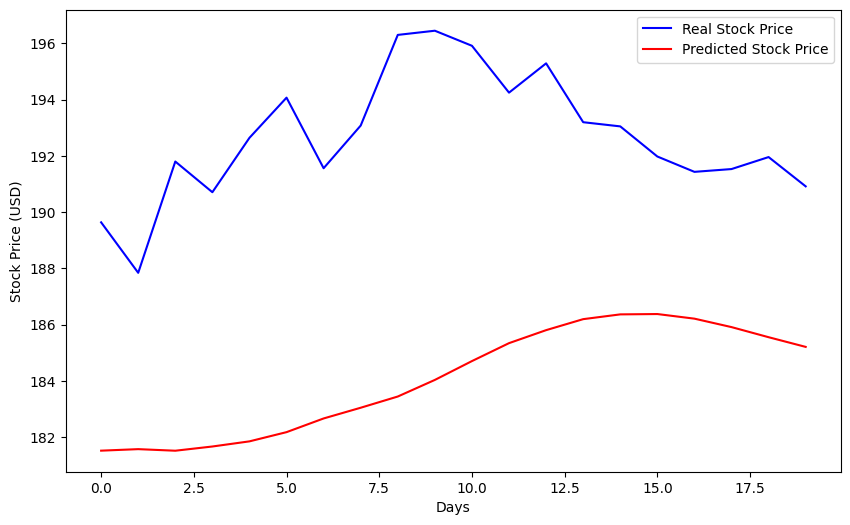

In [25]:
# Visualization
plt.figure(figsize=(10,6))
plt.plot(data['Close'].values[-len(y_test):], color="blue", label="Real Stock Price")
plt.plot(predictions, color="red", label="Predicted Stock Price")
plt.xlabel("Days")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

In [26]:
# Convert y_test back to original scale
actual_future_prices = scaler.inverse_transform(np.array(y_test).reshape(-1,1))
predicted_future_prices = predictions

# Print first 20 days comparison
for day in range(20):
    print(f"Day {day+1}: Actual: {actual_future_prices[day][0]:.2f}, Predicted: {predicted_future_prices[day][0]:.2f}")

Day 1: Actual: 189.63, Predicted: 181.52
Day 2: Actual: 187.84, Predicted: 181.57
Day 3: Actual: 191.80, Predicted: 181.51
Day 4: Actual: 190.71, Predicted: 181.66
Day 5: Actual: 192.64, Predicted: 181.85
Day 6: Actual: 194.07, Predicted: 182.18
Day 7: Actual: 191.56, Predicted: 182.66
Day 8: Actual: 193.08, Predicted: 183.04
Day 9: Actual: 196.30, Predicted: 183.44
Day 10: Actual: 196.45, Predicted: 184.03
Day 11: Actual: 195.91, Predicted: 184.70
Day 12: Actual: 194.25, Predicted: 185.34
Day 13: Actual: 195.29, Predicted: 185.80
Day 14: Actual: 193.19, Predicted: 186.19
Day 15: Actual: 193.05, Predicted: 186.36
Day 16: Actual: 191.97, Predicted: 186.37
Day 17: Actual: 191.43, Predicted: 186.21
Day 18: Actual: 191.53, Predicted: 185.91
Day 19: Actual: 191.95, Predicted: 185.55
Day 20: Actual: 190.91, Predicted: 185.21
